# Modeling and Simulation in Python

Chapter 4: Predict

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [48]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Functions from the previous chapter

In [49]:
def plot_estimates(table):
    """Plot world population estimates.
    
    table: DataFrame with columns `un` and `census`
    """
    un = table.un / 1e9
    census = table.census / 1e9
    
    plot(census, ':', color='darkblue', label='US Census')
    plot(un, '--', color='green', label='UN DESA')
    
    decorate(xlabel='Year',
             ylabel='World population (billion)')

In [50]:
def plot_results(system):
    """Plot the estimates and the model.
    
    system: System object with `results`
    """
    newfig()
    plot_estimates(table2)
    plot(system.results, '--', color='gray', label='model')
    decorate(xlabel='Year', 
             ylabel='World population (billion)')

In [51]:
def run_simulation(system, update_func):
    """Run a model.
    
    Adds TimeSeries to `system` as `results`.

    system: System object
    update_func: function that computes the population next year
    """
    results = Series([])
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
    system.results = results

### Reading the data

In [52]:
# The data directory contains a downloaded copy of
# https://en.wikipedia.org/wiki/World_population_estimates

from pandas import read_html
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')

In [53]:
table2 = tables[2]

In [54]:
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

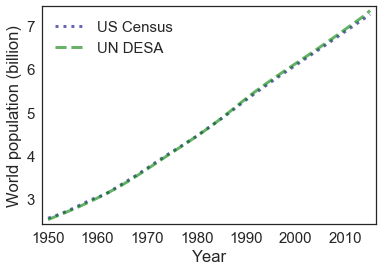

In [55]:
newfig()
plot_estimates(table2)

### Running the quadratic model

Here's the update function for the quadratic growth model with parameters `alpha` and `beta`.

In [56]:
def update_func2(pop, t, system):
    """Update population based on a quadratic model.
    
    pop: current population in billions
    t: what year it is
    system: system object with model parameters
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

Select the estimates generated by the U.S. Census, and convert to billions.

In [57]:
census = table2.census / 1e9

Extract the starting time and population.

In [58]:
t0 = census.index[0]
p0 = census[t0]
t_end = census.index[-1]

Initialize the system object.

In [59]:
system = System(t0=t0, 
                t_end=t_end,
                p0=p0,
                alpha=0.025,
                beta=-0.0018)

system

,value
t0,1950.000000
t_end,2015.000000
p0,2.557629
alpha,0.025000
beta,-0.001800


Run the model and plot results.

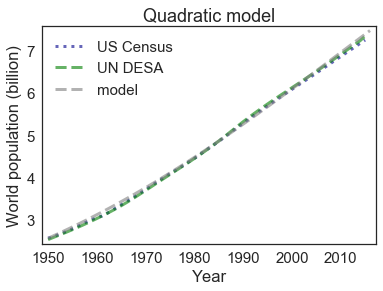

In [60]:
run_simulation(system, update_func2)
plot_results(system)
decorate(title='Quadratic model')

### Generating projections

To generate projections, all we have to do is change `t_end`

Saving figure to file chap04-fig01.pdf


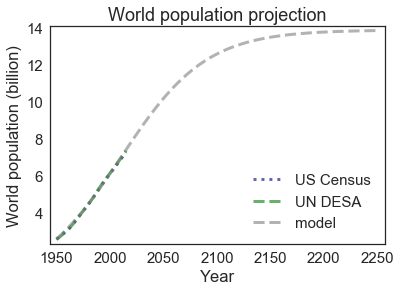

In [61]:
system.t_end = 2250
run_simulation(system, update_func2)
plot_results(system)
decorate(title='World population projection')
savefig('chap04-fig01.pdf')

The population in the model converges on the equilibrium population, `-alpha/beta`

In [62]:
system.results[system.t_end]

13.856665141368708

In [63]:
-system.alpha / system.beta

13.888888888888889

**Exercise:**  What happens if we start with an initial population above the carrying capacity, like 20 billion?  The the model with initial populations between 1 and 20 billion, and plot the results on the same axes.

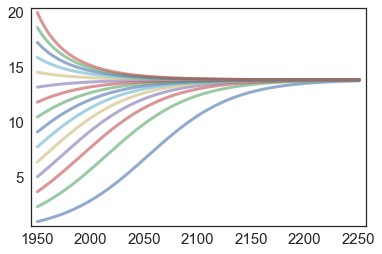

In [64]:
newfig()
p0_array = linspace(1, 20, 15)

for system.p0 in p0_array:
    run_simulation(system, update_func2)
    plot(system.results)

### Comparing projections

We can compare the projection from our model with projections produced by people who know what they are doing.

In [65]:
table3 = tables[3]
table3.head()

,United States Census Bureau (2015)[18],Population Reference Bureau (1973-2015)[6],United Nations Department of Economic and Social Affairs (2015)[7]
Year,,,
2016,7.334772e+09,NaN,7.432663e+09
2017,7.412779e+09,NaN,NaN
2018,7.490428e+09,NaN,NaN
2019,7.567403e+09,NaN,NaN
2020,7.643402e+09,NaN,7.758157e+09


`NaN` is a special value that represents missing data, in this case because some agencies did not publish projections for some years.

In [66]:
table3.columns = ['census', 'prb', 'un']

This function plots projections from the UN DESA and U.S. Census.  It uses `dropna` to remove the `NaN` values from each series before plotting it.

In [67]:
def plot_projections(table):
    """Plot world population projections.
    
    table: DataFrame with columns 'un' and 'census'
    """
    census = table.census / 1e9
    un = table.un / 1e9
    
    plot(census.dropna(), ':', color='darkblue', label='US Census')
    plot(un.dropna(), '--', color='green', label='UN DESA')

Run the model until 2100, which is as far as the other projections go.

In [68]:
system.p0 = census[t0]
system.t_end = 2100
run_simulation(system, update_func2)

Plot the results.

Saving figure to file chap04-fig02.pdf


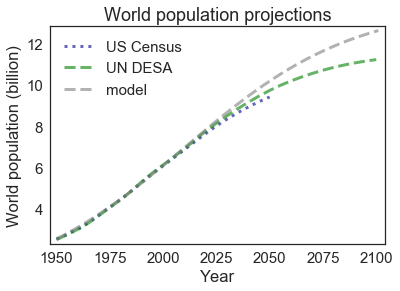

In [69]:
plot_results(system)
plot_projections(table3)
decorate(title='World population projections')
savefig('chap04-fig02.pdf')

People who know what they are doing expect the growth rate to decline more sharply than our model projects.

**Exercise:**  Suppose there are two banks across the street from each other, The First Geometric Bank (FGB) and Exponential Savings and Loan (ESL).  They offer the same interest rate on checking accounts, 3%, but at FGB, they compute and pay interest at the end of each year, and at ESL they compound interest continuously.

If you deposit $p_0$ dollars at FGB at the beginning of Year 0, the balanace of your account at the end of Year $n$ is

$ x_n = p_0 (1 + \alpha)^n $

where $\alpha = 0.03$.  At ESL, your balance at any time $t$ would be

$ x(t) = p_0 \exp(\alpha t) $

If you deposit \$1000 at each back at the beginning of Year 0, how much would you have in each account after 10 years?

Is there an interest rate FGB could pay so that your balance at the end of each year would be the same at both banks?  What is it?

Hint: `modsim` provides a function called `exp`, which is a wrapper for the NumPy function `exp`.

In [70]:
p0 = 1000
alpha = .03
t = linrange(10)

In [71]:
geometric = p0 * (1 + alpha) ** t
geometric

array([ 1000.        ,  1030.        ,  1060.9       ,  1092.727     ,
        1125.50881   ,  1159.2740743 ,  1194.05229653,  1229.87386542,
        1266.77008139,  1304.77318383,  1343.91637934])

In [72]:
exponential = p0 * exp(alpha * t)
exponential

array([ 1000.        ,  1030.45453395,  1061.83654655,  1094.17428371,
        1127.49685158,  1161.83424273,  1197.21736312,  1233.67805996,
        1271.24915032,  1309.96445073,  1349.85880758])

In [73]:
alpha2 = exp(alpha) -1
alpha2

0.030454533953516938

In [74]:
geometric = p0 * (1 + alpha2) ** t
geometric

array([ 1000.        ,  1030.45453395,  1061.83654655,  1094.17428371,
        1127.49685158,  1161.83424273,  1197.21736312,  1233.67805996,
        1271.24915032,  1309.96445073,  1349.85880758])

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


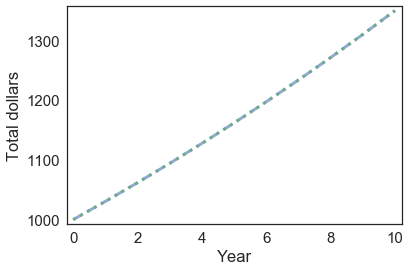

In [75]:
newfig()
plot(t, exponential, '--')
plot(t, geometric, ':')
decorate(xlabel='Year', ylabel='Total dollars')

**Exercise:** Suppose a new bank opens called the Polynomial Credit Union (PCU).  In order to compete with First Geometric Bank and Exponential Savings and Loan, PCU offers a parabolic savings account where the balance is a polynomial function of time:

$ x(t) = p_0 + \beta_1 t + \beta_2 t^2 $

As a special deal, they offer an account with $\beta_1 = 30$ and $\beta_2 = 0.5$, with those parameters guaranteed for life.

Suppose you deposit \$1000 at all three banks at the beginning of Year 0.  How much would you have in each account at the end of Year 10?  How about Year 20?  And Year 100?

In [87]:
number_of_years = 100
t = linrange(number_of_years)
geometric = p0 * (1 + alpha2) ** t
exponential = p0 * exp(alpha * t)

In [88]:
beta1 = 30
beta2 = 0.5
parabolic = p0 + beta1 * t + beta2 * t **2
parabolic

array([ 1000. ,  1030.5,  1062. ,  1094.5,  1128. ,  1162.5,  1198. ,
        1234.5,  1272. ,  1310.5,  1350. ,  1390.5,  1432. ,  1474.5,
        1518. ,  1562.5,  1608. ,  1654.5,  1702. ,  1750.5,  1800. ,
        1850.5,  1902. ,  1954.5,  2008. ,  2062.5,  2118. ,  2174.5,
        2232. ,  2290.5,  2350. ,  2410.5,  2472. ,  2534.5,  2598. ,
        2662.5,  2728. ,  2794.5,  2862. ,  2930.5,  3000. ,  3070.5,
        3142. ,  3214.5,  3288. ,  3362.5,  3438. ,  3514.5,  3592. ,
        3670.5,  3750. ,  3830.5,  3912. ,  3994.5,  4078. ,  4162.5,
        4248. ,  4334.5,  4422. ,  4510.5,  4600. ,  4690.5,  4782. ,
        4874.5,  4968. ,  5062.5,  5158. ,  5254.5,  5352. ,  5450.5,
        5550. ,  5650.5,  5752. ,  5854.5,  5958. ,  6062.5,  6168. ,
        6274.5,  6382. ,  6490.5,  6600. ,  6710.5,  6822. ,  6934.5,
        7048. ,  7162.5,  7278. ,  7394.5,  7512. ,  7630.5,  7750. ,
        7870.5,  7992. ,  8114.5,  8238. ,  8362.5,  8488. ,  8614.5,
        8742. ,  887

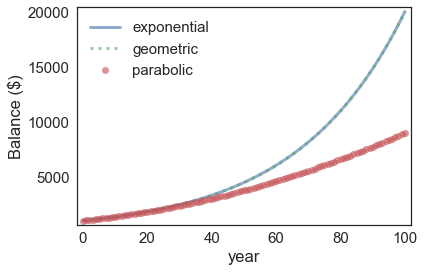

In [90]:
newfig()
plot(t, exponential, '-', label='exponential')
plot(t, geometric, ':', label='geometric')
plot(t, parabolic, 'o', label='parabolic')
decorate(xlabel='year', ylabel='Balance ($)')

In [33]:
# Solution goes here

In [34]:
# Solution goes here